# Ejemplo de ROC Curve

Los datos fueron descargados de: https://www.kaggle.com/blastchar/telco-customer-churn

In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt 
from IPython.display import Image
import pydotplus # Si no lo tienen instalado: conda install -c conda-forge pydotplus

### Importamos los datos

In [2]:
data = pd.read_csv('telcoChurn.csv')

In [3]:
#Imputamos los nulos que figuran como "vacios"
data['TotalCharges'] = data['TotalCharges'].replace(' ',-1).astype(float)

### Convertirmos las variables categóricas a Dummies

In [4]:
# Seleccionamos las variables categóricas
cat_vars = ['gender', 'Partner', 'Dependents', 'PhoneService','MultipleLines', 'InternetService',
           'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
           'PaymentMethod']

In [5]:
# Iteramos sobre cada variable creando su dummie         
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1

In [6]:
# Descartamos las variables originales
data = data.drop(cat_vars, axis = 1)

In [7]:
# El target también los convertimos en una variable numérica dummie
data['target'] = np.where(data.Churn == 'Yes',1,0)

In [8]:
# Eliminamos la variable Target y el ID de cliente que no arroja información (realmente no tiene información?)
data = data.drop(['Churn', 'customerID'], axis = 1)

In [9]:
data.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,target
0,0,1,29.85,29.85,1,0,0,1,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,0,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
2,0,2,53.85,108.15,0,1,1,0,1,0,...,1,0,0,0,1,0,0,0,1,1
3,0,45,42.30,1840.75,0,1,1,0,1,0,...,0,1,0,1,0,1,0,0,0,0
4,0,2,70.70,151.65,1,0,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1


### Separamos las bases y creamos un objeto Metricas

In [10]:
# Separamos la base en las columnas Independientes y la Dependiente (X e Y)
X, y = data.drop(data.columns[-1], axis=1), data.iloc[:,-1]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
#Guardo un objeto con las metricas de mis modelos
metricas = {}

### Entreno los modelos "simples" de clases anteriores

In [13]:
# Entreno un Arbol de Decision
dtree= DecisionTreeClassifier()
dtree.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = dtree.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['decisionTree'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [14]:
#Entreno una Regresión Logistica
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['logisticRegresion'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Entreno modelos Random Forest

In [15]:
#Entreno un Random Forest
RF = RandomForestClassifier()
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['RandomForest'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Grafico las curvas ROC de los modelos para Compararlos

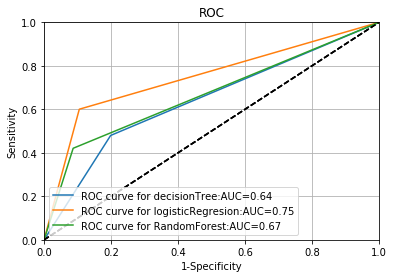

In [16]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()


### ¿Qué pasaría si comienzo a modificar los parámetros de estos modelos nuevos?

Cambiar los parámetros -> Guardar las nuevas métricas -> Volver a graficar las Curvas ROC

In [17]:
#Entreno una Regresión Logistica
logreg = LogisticRegression(random_state=42, solver='lbfgs',multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['logisticRegresion'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
# Entreno un Arbol de Decision
dtree= DecisionTreeClassifier(random_state=42)
dtree.fit(X_train,y_train)

# Me guardo las Metricas que necesito para graficar
y_pred = dtree.predict(X_test)
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas ['decisionTree'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [19]:
#Entreno un Random Forest

RF = RandomForestClassifier(n_estimators=200, max_depth=10,max_features=0.7, random_state=42, criterion='entropy')
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['RandomForest'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

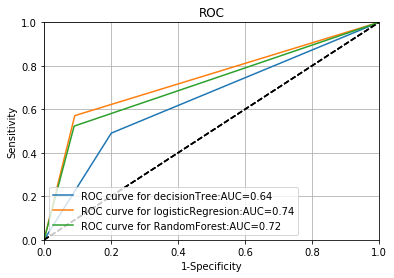

In [20]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()

### ¿Qué pasaría si optimizo los parámetros con Greedy Search o Random Search?

Optimizar por Greedy/Random Search -> Guardar las nuevas métricas -> Volver a graficar las Curvas ROC

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [26]:
random_grid = {'n_estimators': [50,100,150],
               'max_features': [0.3,0.5,0.7],
               'max_depth': [1,10,20],
              'criterion':('gini', 'entropy')}

In [27]:
RF = RandomForestClassifier()
clf = GridSearchCV(RF, random_grid, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 100, 150], 'max_features': [0.3, 0.5, 0.7], 'max_depth': [1, 10, 20], 'criterion': ('gini', 'entropy')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
clf.best_estimator_
# Predigo
y_pred = clf.predict(X_test)
# Me guardo las Metricas que necesito para graficar
auc = metrics.roc_auc_score(np.asarray(y_test), y_pred)
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), y_pred)
metricas['RandomForest_GS'] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

In [29]:
print(random_grid)

{'n_estimators': [50, 100, 150], 'max_features': [0.3, 0.5, 0.7], 'max_depth': [1, 10, 20], 'criterion': ('gini', 'entropy')}


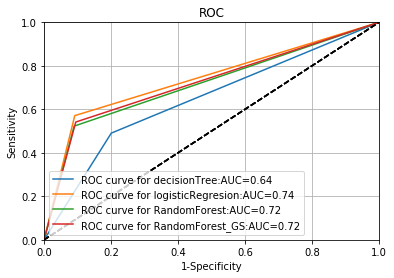

In [30]:
# Grafico la Curva ROC con los valores de mis modelos
for modelName in metricas:
    label = 'ROC curve for {0}:'.format(modelName)
    plt.plot(metricas[modelName]['fpr'], metricas[modelName]['tpr'], label=label+'AUC={0:0.2f}'.format(metricas[modelName]['auc']))
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'k--')

plt.grid(True)
plt.title('ROC')
plt.legend(loc="lower left")
plt.show()

La idea es que saques un Grid search para cada modelo y veas que columna performa mejor para que veas con que te quedas como mejor predictor. 